<a href="https://colab.research.google.com/github/dookda/cmu_water_balance/blob/main/watbalance_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import ee
# ใน Google Colab ต้องใช้ ee.Authenticate() แทน earthengine authenticate เพราะ Colab ไม่มี CLI เหมือนเครื่อง Local
ee.Authenticate()

# Initialize the session
ee.Initialize(project="ee-sakda-451407")

In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# จุดที่สนใจ (เชียงใหม่)
region = ee.Geometry.Point([99.0, 18.8])

# โหลดข้อมูล CHIRPS รายวัน และรวมรายเดือน
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate('1990-01-01', '2023-12-31') \
    .filterBounds(region) \
    .select('precipitation')

# สร้างภาพรายเดือน
def create_monthly_images(year):
    year = ee.Number(year)
    months = ee.List.sequence(1, 12)
    def create_month(month):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')
        image = chirps.filterDate(start, end).sum().set('system:time_start', start.millis())
        return image
    return months.map(create_month)

years = ee.List.sequence(2000, 2023)
monthly = ee.ImageCollection(years.map(create_monthly_images).flatten())

# คำนวณค่าเฉลี่ยรายเดือนที่จุด
def image_to_feature(img):
    mean = ee.Image(img).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000
    )
    return ee.Feature(None, {
        'rainfall': mean.get('precipitation'),
        'date': ee.Image(img).date().format('YYYY-MM-dd')
    })

features = monthly.map(image_to_feature)

# ดึงข้อมูลลงมาเป็น pandas dataframe
fc = ee.FeatureCollection(features)
data = fc.getInfo()['features']
df = pd.DataFrame([{
    'date': f['properties']['date'],
    'rainfall': f['properties']['rainfall']
} for f in data])

# จัดการวันที่และ missing
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()
df['rainfall'] = pd.to_numeric(df['rainfall'], errors='coerce').fillna(0)

# แยกข้อมูล
rain = df["rainfall"].values
dates = df.index.values

# Normalize
scaler = MinMaxScaler()
rain = scaler.fit_transform(rain.reshape(-1, 1))

# สร้าง sequence สำหรับ LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(rain, sequence_length)

print("ตัวอย่างข้อมูลเข้า LSTM (X):", X.shape)
print("ตัวอย่างผลลัพธ์ (y):", y.shape)
print("วันที่เริ่มต้น:", dates[sequence_length])


ตัวอย่างข้อมูลเข้า LSTM (X): (276, 12, 1)
ตัวอย่างผลลัพธ์ (y): (276, 1)
วันที่เริ่มต้น: 2001-01-01T00:00:00.000000000


In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# แบ่ง train/test (เช่น 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # ไม่ shuffle เพราะเป็นข้อมูลเวลา
)

In [ ]:
# type 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

# ฝึกโมเดล
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

In [ ]:
# type 2

# สร้างโมเดล LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


In [ ]:
# type 3
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

In [ ]:
# type 4
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

# ฝึกโมเดล
model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

In [ ]:
# type 5

model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


In [ ]:
# type 6
from tensorflow.keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='tanh'), input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

In [101]:
# type 7
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(sequence_length, 1)))
model.add(LSTM(32, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - loss: 0.0996 - val_loss: 0.0627
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0622 - val_loss: 0.0603
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0583 - val_loss: 0.0607
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0555 - val_loss: 0.0578
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0488 - val_loss: 0.0548
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0477 - val_loss: 0.0529
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0480 - val_loss: 0.0529
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0477 - val_loss: 0.0477
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0481 - val_loss: 0.0452
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0530 - val_loss: 0.0412
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0413 - val_loss: 0.0374
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0469 - val_l

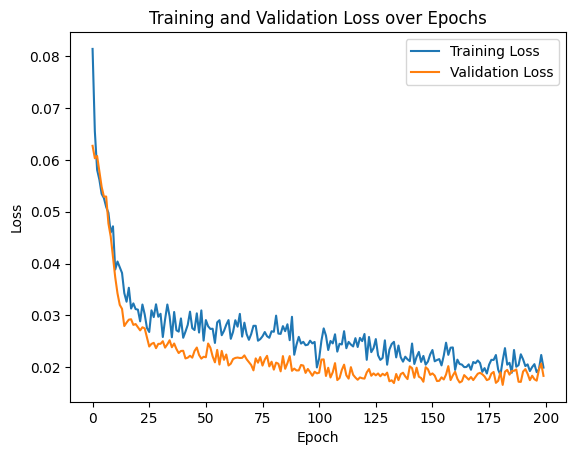

In [102]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


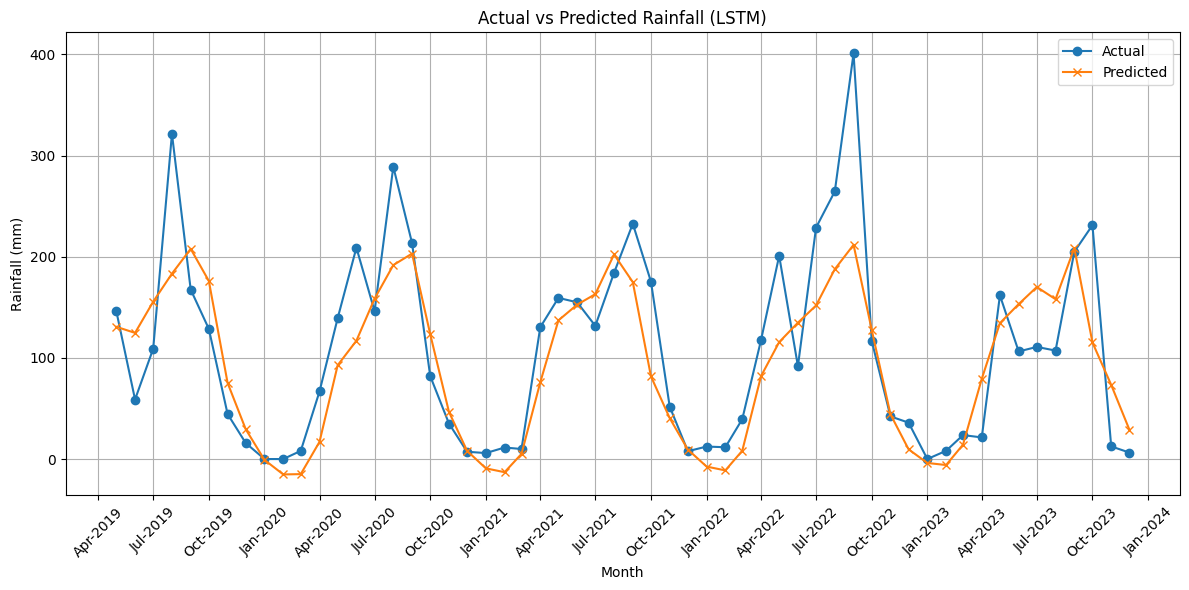

  Model    MAE   RMSE  MAPE (%)     R²
0  LSTM  39.82  54.34       NaN  0.668


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ฟังก์ชันประเมินผลโมเดล
def evaluate_model(model_name, y_true, y_pred, dates, results=[]):
    # แปลงค่าจาก normalize กลับมาเป็น scale เดิม
    y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # คำนวณ metric
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    r2 = r2_score(y_true_inv, y_pred_inv)
    mape = np.mean(np.abs((y_true_inv - y_pred_inv) / y_true_inv)) * 100 if np.all(y_true_inv != 0) else np.nan

    # เก็บผลลัพธ์
    results.append({
        'Model': model_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE (%)': round(mape, 2),
        'R²': round(r2, 3)
    })

    # พล็อตกราฟผลการพยากรณ์
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true_inv, label='Actual', marker='o')
    plt.plot(dates, y_pred_inv, label='Predicted', marker='x')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.xlabel("Month")
    plt.ylabel("Rainfall (mm)")
    plt.title(f"Actual vs Predicted Rainfall ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# ทำนายจากโมเดล
y_pred = model.predict(X_test)

# วันที่ที่ตรงกับ y_test
test_start_index = len(dates) - len(y_test)
date_range = dates[test_start_index:]

# สร้าง list สำหรับเก็บผลหลายโมเดล
results = []

# ประเมินและพล็อต
results = evaluate_model("LSTM", y_test, y_pred, date_range, results)

# แสดงตารางเปรียบเทียบ
df_results = pd.DataFrame(results)
print(df_results)


In [44]:
# Make predictions for the next month
future_sequence = rain[-sequence_length:].reshape(1, sequence_length, 1)
print(future_sequence)
predicted_scaled = model.predict(future_sequence)
predicted_rainfall = scaler.inverse_transform(predicted_scaled)[0][0]

print(f"Predicted rainfall for the next month: {predicted_rainfall:.2f} mm")


[[[0.        ]
  [0.02027323]
  [0.05903843]
  [0.05328644]
  [0.40352995]
  [0.26523346]
  [0.27636028]
  [0.26740447]
  [0.51092491]
  [0.57653997]
  [0.03112356]
  [0.01601005]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted rainfall for the next month: 0.57 mm


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

ปริมาณฝนที่พยากรณ์ล่วงหน้า 12 เดือน:
2024-01-01: 0.57 mm
2024-02-01: 2.72 mm
2024-03-01: 24.76 mm
2024-04-01: 64.88 mm
2024-05-01: 126.70 mm
2024-06-01: 146.47 mm
2024-07-01: 168.81 mm
2024-08-01: 182.37 mm
2024-09-01: 203.94 mm
2024-10-01: 168.09 mm
2024-11-01: 36.95 mm
2024-12-01: 8.00 mm


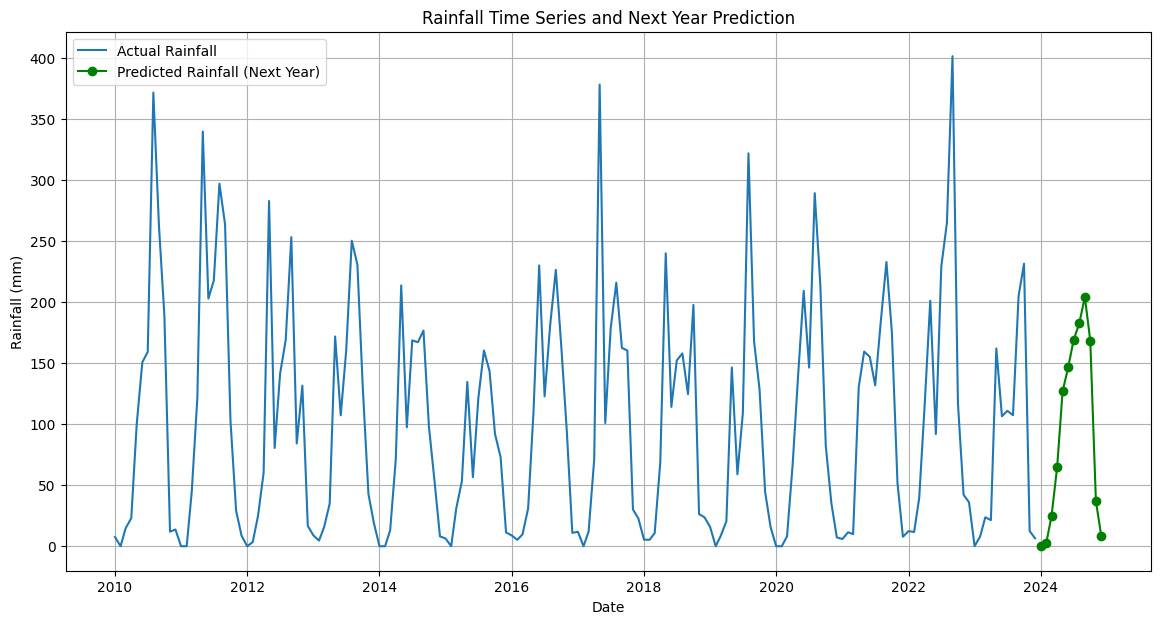

In [51]:
# แบบที่ 1: ขยายช่วงวันที่ให้ครอบคลุมปีถัดไปอีก 12 เดือน
last_date = pd.to_datetime(dates[-1])
future_dates = pd.date_range(start=last_date, periods=13, freq='MS')[1:]  # เริ่มต้นเดือนถัดจากข้อมูลล่าสุด (รวมทั้งหมด 12 เดือน)

# เตรียม sequence สุดท้ายจากข้อมูลที่ฝึก เพื่อใช้พยากรณ์ลำดับถัดไป
current_sequence = rain[-sequence_length:].reshape(1, sequence_length, 1)

# รายการเก็บค่าที่พยากรณ์แบบ normalize
future_predictions_scaled = []

# พยากรณ์ฝนล่วงหน้า 12 เดือน
for _ in range(12):
    predicted_scaled_next = model.predict(current_sequence)
    future_predictions_scaled.append(predicted_scaled_next[0][0])

    # อัปเดตลำดับใหม่ โดยลบตัวแรก และต่อท้ายด้วยค่าที่พยากรณ์ได้
    current_sequence = np.append(current_sequence[:, 1:, :], predicted_scaled_next.reshape(1, 1, 1), axis=1)

# แปลงค่าฝนที่พยากรณ์จาก normalized กลับไปเป็นค่าจริง (mm)
predicted_rainfall_next_year = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1)).flatten()

# แสดงค่าที่พยากรณ์ได้
print("\nปริมาณฝนที่พยากรณ์ล่วงหน้า 12 เดือน:")
for date, rainfall in zip(future_dates, predicted_rainfall_next_year):
    print(f"{date.strftime('%Y-%m-%d')}: {rainfall:.2f} mm")


# เตรียมข้อมูลสำหรับการพล็อตกราฟ
# สร้างซีรีส์ของข้อมูลฝนจริง
actual_series = pd.Series(scaler.inverse_transform(rain).flatten(), index=pd.to_datetime(dates))

# สร้างซีรีส์ของข้อมูลฝนที่พยากรณ์ไว้สำหรับปีหน้า
predicted_series_next_year = pd.Series(predicted_rainfall_next_year, index=future_dates)

# รวมข้อมูลจริงและข้อมูลที่พยากรณ์ไว้สำหรับการพล็อต
combined_series_next_year = pd.concat([actual_series, predicted_series_next_year])

# พล็อตกราฟแสดงข้อมูลฝนจริงและค่าที่พยากรณ์ไว้ในปีถัดไป
plt.figure(figsize=(14, 7))
plt.plot(actual_series.index, actual_series.values, label='Actual Rainfall')
plt.plot(predicted_series_next_year.index, predicted_series_next_year.values, 'go-', label='Predicted Rainfall (Next Year)') # 'go-' for green circle marker and line
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Time Series and Next Year Prediction')
plt.legend()
plt.grid(True)
plt.show()
